In [10]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(font_scale=2)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

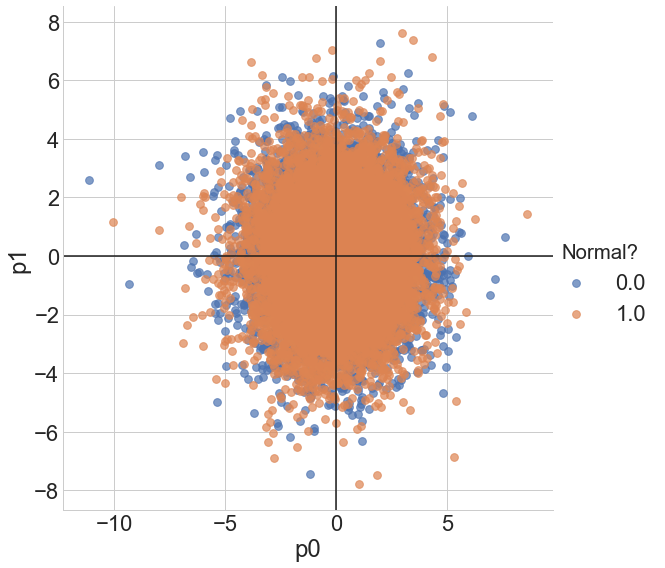

In [13]:
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
from scipy.io import wavfile
import numpy as np
from librosa.core import resample

sample_rate, samples = wavfile.read('audio_normal.wav')
#downsampling to 10000Hz
sr = 9000
resampled = resample(samples.astype(np.float32),sample_rate,sr) 
#make sure every signal is within the range of (0,1)
samples_casted = resampled / (2.**15) 
seg_len = sr/40 #25ms
overlap = seg_len*0.6  #60% overlap
f, t, Zxx = signal.stft(samples_casted, fs = sr, nperseg = seg_len, noverlap = overlap)
Zxx_abs = np.abs(Zxx)
audio_normal = Zxx.real

cols = ['Normal?']
for i in range(len(f)):
    cols.append((str(f[i])+'Hz'))
    
A_data = np.array([[0.0 for i in range(len(f)+1)] for i in range(len(t))])
for i in range(1,len(t)):
    row = np.array([1.0])
    row = np.append(row, audio_normal[:,i])
    A_data[i] = row
df = pd.DataFrame(np.array([A_data[i] for i in range(len(t))]), columns = cols)


sample_rate, samples = wavfile.read('audio_abnormal.wav')
#downsampling to 9000Hz
sr = 9000
resampled = resample(samples.astype(np.float32),sample_rate,sr) 

#make sure every signal is within the range of (0,1)
samples_casted = resampled / (2.**15) 
seg_len = sr/40 #25ms
overlap = seg_len*0.6  #60% overlap
f, t, Zxx = signal.stft(samples_casted, fs = sr, nperseg = seg_len, noverlap = overlap)
Zxx_abs = np.abs(Zxx)

audio_abnormal = Zxx.real
cols = ['Normal?']
for i in range(len(f)):
    cols.append((str(f[i])+'Hz'))
    
A_data = np.array([[0.0 for i in range(len(f)+1)] for i in range(len(t))])
for i in range(1,len(t)):
    row = np.array([0.0])
    row = np.append(row, audio_abnormal[:,i])
    A_data[i] = row
df_audio = pd.DataFrame(np.array([A_data[i] for i in range(len(t))]), columns = cols)
#DataFrame appending --> Mixed audio
df_audio = df_audio.append(df)

#####PCA#####
Audio_s = df_audio.iloc[:,1:]
#X: shifted dataset (each feature has mean value of zero)
X = Audio_s - Audio_s.mean()
#Z: shifted and standardized dataset 
Z = X / Audio_s.std()
U, S, Vt = np.linalg.svd(Z, full_matrices=False)
variances = S**2
V = Vt.T

tot = sum(variances)
var_exp = [(i / tot)*100 for i in variances]
cum_var_exp = np.cumsum(var_exp)

###Take n_components = 50
Zstar = Z@V[:,:50]
df_audio['p0'] = Zstar.values[:,0]
df_audio['p1'] = Zstar.values[:,1]

#PCA plotting for PC0 and PC1
g1 = sns.lmplot('p0', 'p1', df_audio, hue='Normal?', fit_reg=False, height=8, scatter_kws={'alpha':0.7,'s':60})
ax = g1.axes[0,0]
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
headers = df_audio.columns.values.tolist()

In [16]:
audio_pca = Zstar

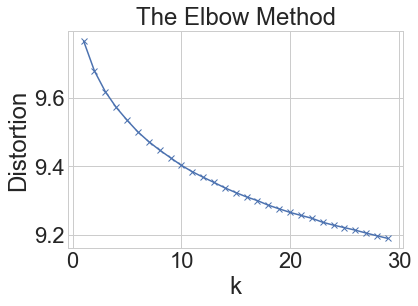

In [23]:
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(audio_pca)
    kmeanModel.fit(audio_pca)
    distortions.append(sum(np.min(cdist(audio_pca, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / audio_pca.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

In [29]:
kmeans = KMeans(n_clusters=11, random_state=0).fit(audio_pca)
labels_k = kmeans.labels_
print("labels_k--",labels_k, '\n',"#data points", len(labels_k), '\n')
print("k_cluster centers:\n", kmeans.cluster_centers_)

labels_k-- [ 8 10  2 ...  5  1  8] 
 #data points 24002 

k_cluster centers:
 [[-3.77854397e-01  7.56697339e-01 -9.67324816e-01 -2.10165761e+00
  -2.26621725e-01  2.89971452e-01 -6.35780085e-01 -9.74730736e-02
   1.67460429e-01  7.02272500e-01  1.68144111e-01  2.85841333e-01
   1.44335421e-01 -4.33828821e-02 -4.64035744e-01 -1.90658020e-01
   4.14677923e-01  9.89517770e-02 -1.09549742e-01 -3.61148893e-03
   1.03086776e-01  2.30165044e-02 -9.63351974e-02  1.00498756e-01
   8.76182406e-02 -5.40078865e-02  8.14389284e-02 -2.41115189e-02
   7.05847605e-02  2.99117827e-02  1.18254214e-01  6.24758322e-02
  -9.45822279e-03 -2.94775968e-02 -8.92607229e-02  9.27831079e-02
  -9.44289612e-02 -8.62011116e-02 -4.40587496e-02 -2.93430184e-02
   4.96596745e-02  3.82970959e-03  2.58425103e-02  2.56073247e-03
  -6.97830368e-04 -1.07003141e-03 -8.14470080e-03 -8.73363550e-02
  -1.49503594e-02 -3.11695747e-02]
 [-9.81567806e-02  9.44226625e-01 -4.84720160e-01 -2.85404299e-01
   9.15312878e-01  3.99878561

In [39]:
centers = kmeans.cluster_centers_
indices = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
#points = {i: [audio_pca[j] for j in np.where(kmeans.labels_ == i)] for i in range(kmeans.n_clusters)}
#min_indices = {}
#for i in range(kmeans.n_clusters):
#    distances = [np.linalg.norm(a-centers[i]) for a in points[i]]
#    min_indices[i] = distances.index(min(distances))

In [ ]:
print("cluster indices\n",indices)
print("center coordinates--\n",points) 
print("center indices\n",min_indices)

In [ ]:
import collections
collections_k = collections.Counter(labels_k)
print(collections_k)